# Importing and Visualizing the Dataset

Total training image count: 5216
Found 5216 files belonging to 2 classes.
Using 4695 files for training.
Found 5216 files belonging to 2 classes.
Using 521 files for validation.
Found 624 files belonging to 2 classes.


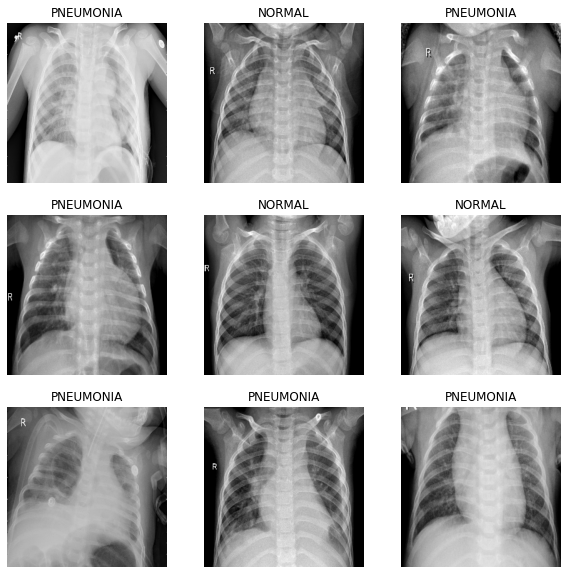

In [1]:
import pathlib
import PIL
import matplotlib.pyplot as plt
from tensorflow import keras

data_dir = pathlib.Path("./chest_xray/train/")
test_dir = pathlib.Path("./chest_xray/test/")
val_dir = pathlib.Path("./chest_xray/val/")
image_count = len(list(data_dir.glob('*/*.jpeg')))
print("Total training image count:", image_count)

norm = list(data_dir.glob("NORMAL/*"))
pneum = list(data_dir.glob("PNEUMONIA/*"))
#PIL.Image.open(str(norm[0]))
#PIL.Image.open(str(pneum[0]))

dataset = keras.preprocessing.image_dataset_from_directory(data_dir, batch_size=32, validation_split=0.1, subset="training", seed=0)
val_data = keras.preprocessing.image_dataset_from_directory(data_dir, batch_size=32, validation_split=0.1, subset="validation", seed=0)
#val_dataset = keras.preprocessing.image_dataset_from_directory(val_dir, batch_size=16)

test_dataset = keras.preprocessing.image_dataset_from_directory(test_dir, batch_size=32)

plt.figure(figsize=(10, 10))
for images, labels in dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(dataset.class_names[labels[i]])
    plt.axis("off")

# Caching the Dataset to Memory

In [2]:
dataset = dataset.cache().shuffle(1000).prefetch(buffer_size=32)
val_data = val_data.cache().shuffle(1000).prefetch(buffer_size=32)

# Augmenting the Data to Reduce Overfitting

In [45]:
data_augmentor = keras.Sequential([
    layers.experimental.preprocessing.Resizing(256,256),
    layers.experimental.preprocessing.Rescaling(1./255),

    layers.experimental.preprocessing.RandomFlip("horizontal"),
    # Other preprocessing transformations cause the model to crash. Look into this.
    #layers.experimental.preprocessing.RandomRotation(0.1),
    #layers.experimental.preprocessing.RandomZoom(0.1)
])

# Initializing the Network Layers

In [46]:
from tensorflow.keras import layers

model = keras.Sequential([
    

    data_augmentor,

    layers.Conv2D(32, 3, padding='same', activation="relu"),
    layers.MaxPooling2D(),

    layers.Conv2D(32, 3, padding='same', activation="relu"),
    layers.MaxPooling2D(),

    layers.Conv2D(64, 3, padding='same', activation="relu"),
    layers.MaxPooling2D(),

    layers.Flatten(),
    layers.Dense(128,activation="relu"),
    layers.Dropout(0.5),

    layers.Dense(1, activation="sigmoid")
])

model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["binary_accuracy"]
)

#model.summary()

# Training the Model

In [47]:
early_stopping = keras.callbacks.EarlyStopping(
    patience=5,
    min_delta=0.001,
    restore_best_weights=True,
)

epochs=30
history = model.fit(
  dataset,
  validation_data=val_data,
  epochs=epochs,
  callbacks=[early_stopping]
)

Epoch 1/30
147/147 [==============================] - 102s 695ms/step - loss: 0.2446 - binary_accuracy: 0.8999 - val_loss: 0.1626 - val_binary_accuracy: 0.9463
Epoch 2/30
147/147 [==============================] - 103s 697ms/step - loss: 0.1281 - binary_accuracy: 0.9529 - val_loss: 0.0806 - val_binary_accuracy: 0.9731
Epoch 3/30
147/147 [==============================] - 102s 693ms/step - loss: 0.1181 - binary_accuracy: 0.9583 - val_loss: 0.1114 - val_binary_accuracy: 0.9693
Epoch 4/30
147/147 [==============================] - 101s 684ms/step - loss: 0.1021 - binary_accuracy: 0.9627 - val_loss: 0.0603 - val_binary_accuracy: 0.9789
Epoch 5/30
147/147 [==============================] - 102s 696ms/step - loss: 0.0821 - binary_accuracy: 0.9689 - val_loss: 0.0739 - val_binary_accuracy: 0.9750
Epoch 6/30
147/147 [==============================] - 101s 687ms/step - loss: 0.0696 - binary_accuracy: 0.9753 - val_loss: 0.0854 - val_binary_accuracy: 0.9827
Epoch 7/30
147/147 [====================

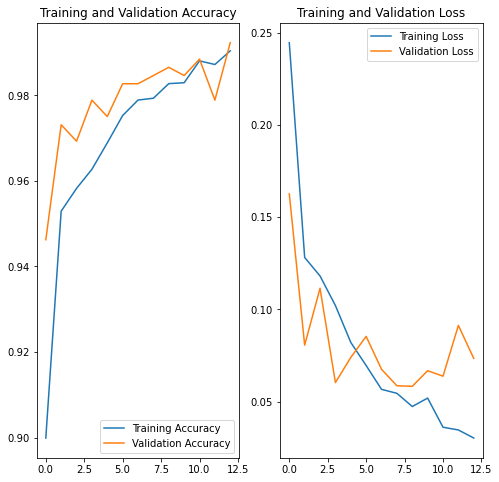

In [48]:
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(max(history.epoch)+1)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Evaluating on Test Data

In [49]:
results = model.evaluate(test_dataset)
print("Test loss, Test accuracy:", results)

20/20 [==============================] - 5s 240ms/step - loss: 0.8845 - binary_accuracy: 0.7837
Test loss, Test accuracy: [0.8845099210739136, 0.7836538553237915]
